## 2. Preparação dos dados
![Data Preparation](./img/imagem2.jpg "Preparação dos dados")

### Objetivos 

* Identificar e corrigir inconsistências, valores em falta ou inválidos.
* Transformar os dados, se necessário, para uniformizar as variáveis.
* Preencher valores em falta com métodos apropriados.
* Garantir que os dados estão equilibrados, especialmente em casos de classes desiguais.
* Selecionar os dados mais relevantes.
* Reduzir o volume total de dados, mantendo informação essencial.
* Obter uma amostra representativa dos registos.
* Reduzir o número de variáveis, mantendo as mais significativas.
* Agrupar valores contínuos em categorias.
* Criar novas variáveis com base nas existentes.

--- 

## 2.1 - Bibliotecas Utilizadas

In [98]:
# Importar Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 2.2 - Dataset Original
https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [99]:
# Ler o arquivo CSV "Life Expectancy Data.csv" guaradado na pasta data e carregar o ficheiro para um DataFrame designado de "df_original".
df_original = pd.read_csv('./data/Life Expectancy Data.csv')


# 2.3 - Informações Gerais Dataset

- Primeiras linhas do dataset
- Principais informações do dataset
- Estatísticas do dataset

In [100]:
# Visualização dos primeiros registos

df_original.head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [101]:
# Informações sobre o DataFrame, incluindo número de entradas, tipos de dados e valores não nulos.

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [102]:
# Estatísticas descritivas (média, desvio padrão, mínimo, máximo

df_original.describe().round(2)

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.00,2928.00,2928.00,2938.00,2744.00,2938.00,2385.00,2938.00,2904.00,2938.00,2919.00,2712.00,2919.00,2938.00,2490.00,2.286000e+03,2904.00,2904.00,2771.00,2775.00
mean,2007.52,69.22,164.80,30.30,4.60,738.25,80.94,2419.59,38.32,42.04,82.55,5.94,82.32,1.74,7483.16,1.275338e+07,4.84,4.87,0.63,11.99
std,4.61,9.52,124.29,117.93,4.05,1987.91,25.07,11467.27,20.04,160.45,23.43,2.50,23.72,5.08,14270.17,6.101210e+07,4.42,4.51,0.21,3.36
min,2000.00,36.30,1.00,0.00,0.01,0.00,1.00,0.00,1.00,0.00,3.00,0.37,2.00,0.10,1.68,3.400000e+01,0.10,0.10,0.00,0.00
25%,2004.00,63.10,74.00,0.00,0.88,4.69,77.00,0.00,19.30,0.00,78.00,4.26,78.00,0.10,463.94,1.957932e+05,1.60,1.50,0.49,10.10
50%,2008.00,72.10,144.00,3.00,3.76,64.91,92.00,17.00,43.50,4.00,93.00,5.76,93.00,0.10,1766.95,1.386542e+06,3.30,3.30,0.68,12.30
75%,2012.00,75.70,228.00,22.00,7.70,441.53,97.00,360.25,56.20,28.00,97.00,7.49,97.00,0.80,5910.81,7.420359e+06,7.20,7.20,0.78,14.30
max,2015.00,89.00,723.00,1800.00,17.87,19479.91,99.00,212183.00,87.30,2500.00,99.00,17.60,99.00,50.60,119172.74,1.293859e+09,27.70,28.60,0.95,20.70


In [103]:
# Verificar se existem valores duplicados

print(f"Valores duplicados: {df_original.duplicated().sum()}")


Valores duplicados: 0


# 2.4 - Preparaçao Dataset

- Limpar os nomes das colunas
- Verificar se existem valores nulos
- Tratar valores ausentes ou nulos
- Confirmar se temos valores duplicados
- Confirmar quais valores únicos de cada variável

In [104]:
#Renomeação das colunas - Retirar os espaços

df_original.columns = df_original.columns.str.strip()

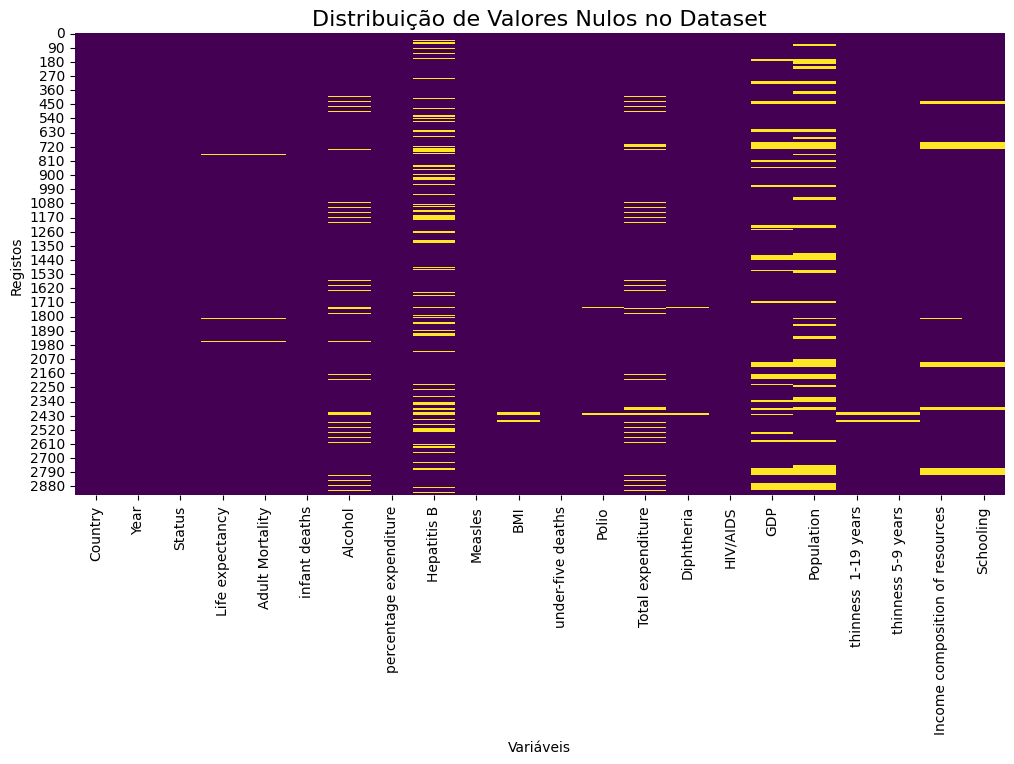

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

In [105]:
# Visualizar a distribuição dos valores nulos
plt.figure(figsize=(12, 6))
sns.heatmap(df_original.isnull(), cbar=False, cmap='viridis')
plt.title("Distribuição de Valores Nulos no Dataset", fontsize=16)
plt.xlabel("Variáveis")
plt.ylabel("Registos")
plt.show()

df_original.isnull().sum()

# Criação do novo DataFrame "Limpo":

Colunas Selecionadas:
* Life expectancy: Expectativa de vida.
* percentage expenditure: Percentual de despesas em saúde.
* Hepatitis B: Cobertura vacinal contra hepatite B.
* Polio: Cobertura vacinal contra poliomielite.
* Total expenditure: Despesas totais em saúde.
* Diphtheria: Cobertura vacinal contra difteria.
* GDP: Produto Interno Bruto.
* Income composition of resources: Composição de recursos de renda.
* Schooling: Anos de escolaridade.


In [106]:
# Lista de colunas a manter

columns_to_keep = [
    "Life expectancy",
    "percentage expenditure",
    "Hepatitis B",
    "Polio",
    "Total expenditure",
    "Diphtheria",
    "GDP",
    "Income composition of resources",
    "Schooling"
]


In [107]:
# Função para filtrar e limpar o DataFrame
def filter_columns_and_clean(df, columns_to_keep):
    
    # Filtrar o DataFrame
    filtered_df = df[columns_to_keep]
    
    # Remover registros com valores nulos
    cleaned_df = filtered_df.dropna()
    
    return cleaned_df

# Aplicar a função ao DataFrame original
df_cleaned = filter_columns_and_clean(df_original, columns_to_keep)

# Exibir informações do DataFrame limpo
df_cleaned.info()

# Total de dados de nulos
df_cleaned.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 0 to 2937
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Life expectancy                  1863 non-null   float64
 1   percentage expenditure           1863 non-null   float64
 2   Hepatitis B                      1863 non-null   float64
 3   Polio                            1863 non-null   float64
 4   Total expenditure                1863 non-null   float64
 5   Diphtheria                       1863 non-null   float64
 6   GDP                              1863 non-null   float64
 7   Income composition of resources  1863 non-null   float64
 8   Schooling                        1863 non-null   float64
dtypes: float64(9)
memory usage: 145.5 KB


Life expectancy                    0
percentage expenditure             0
Hepatitis B                        0
Polio                              0
Total expenditure                  0
Diphtheria                         0
GDP                                0
Income composition of resources    0
Schooling                          0
dtype: int64

Os dados foram limpos e todas as linhas com valores nulos foram removidas. Aqui estão as observações:

Não existe mais valores nulos no dataset.

O dataset original tinha 2.938 registos e 22 colunas.

Após a remoção, registamos 1.649 entradas.

---
# 2.5 - Análise exploratória/estatististica do Dataframe "Limpo"

1. Estatísticas descritivas: Resumo estatístico para variáveis numéricas e sua distribuição.
2. Distribuição das variáveis: Identificação de padrões ou possíveis outliers.
3. Correlação entre variáveis: Análise da relação entre elas, para detectar redundâncias ou dependências.


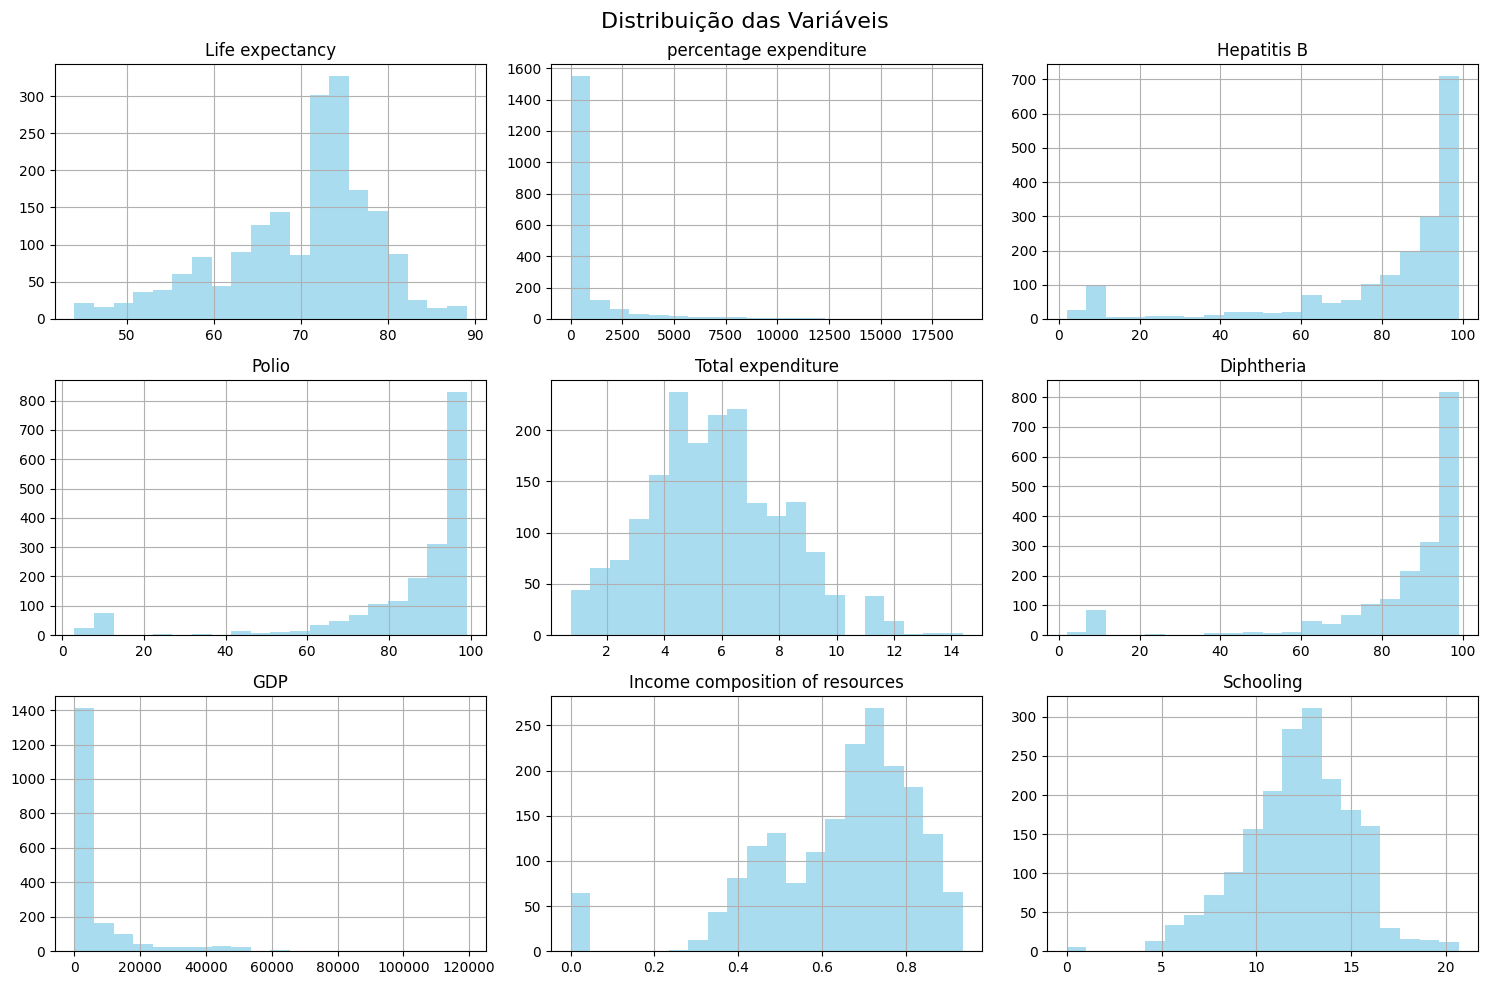

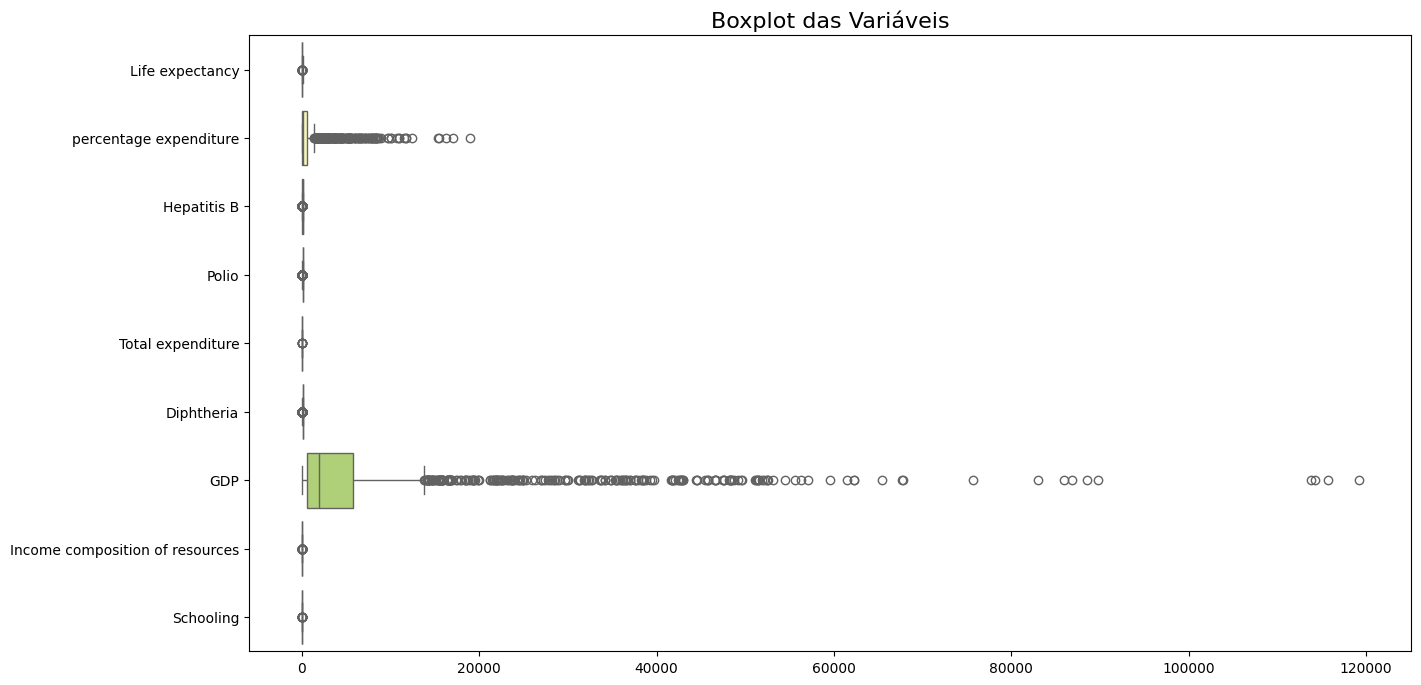

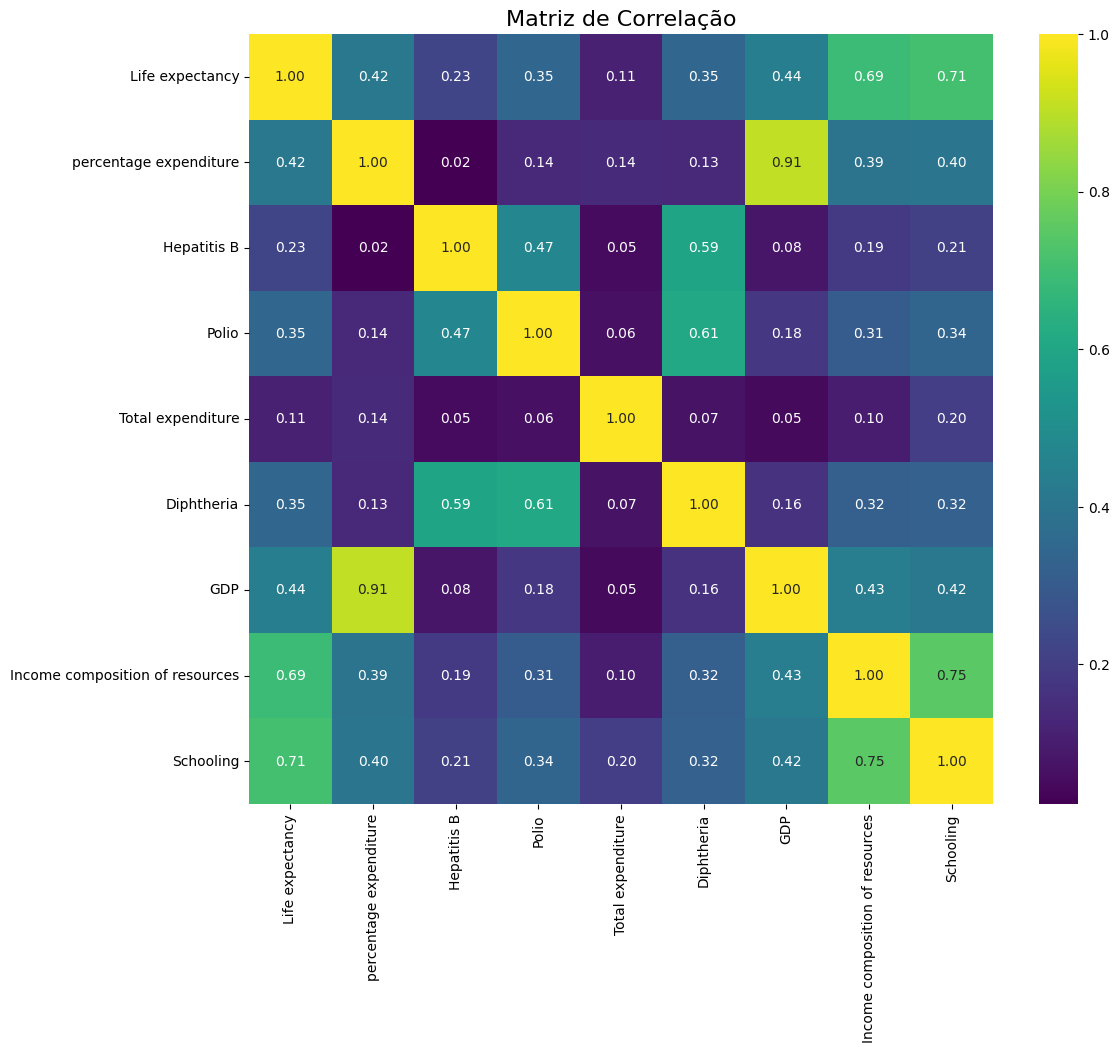

In [108]:

# Distribuição dos dados: Histogramas 
df_cleaned.hist(bins=20, figsize=(15, 10), color='skyblue', alpha=0.7)
plt.suptitle("Distribuição das Variáveis", fontsize=16)
plt.tight_layout()
plt.show()

# Distribuição dos dados: Boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_cleaned, orient='h', palette="Set3")
plt.title("Boxplot das Variáveis", fontsize=16)
plt.show()

# Analisar correlações: Matriz de correlação com heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Matriz de Correlação", fontsize=16)
plt.show()


# Distribuição das Variáveis (Histogramas):

- Variáveis como GDP e percentage expenditure possuem caudas longas, indicando outliers ou diferenças significativas entre registos.

- Analise evidencia a presença de outliers em várias variáveis, como GDP, percentage expenditure, e Total expenditure.
- Variáveis como Schooling e Life expectancy têm distribuições mais centradas e próximas da normalidade.

- Temos assim a confirmação das variáveis Schooling e Income composition of resources estão fortemente correlacionadas com Life expectancy (> 0.7).
- E temos uma correlação mais moderada das variáveis Polio, Diphtheria, e Hepatitis B que demostram correlação positiva mas mais reduzida com Life expectancy.


In [109]:
# Transformar GDP e percentage expenditure usando logaritmo

df_cleaned['GDP'] = np.log1p(df_cleaned['GDP'])  
df_cleaned['percentage expenditure'] = np.log1p(df_cleaned['percentage expenditure'])


* Transformação Logarítmica
1. Reduz o impacto de valores extremos, especialmente em variáveis com caudas longas.
2. Útil para variáveis positivas.

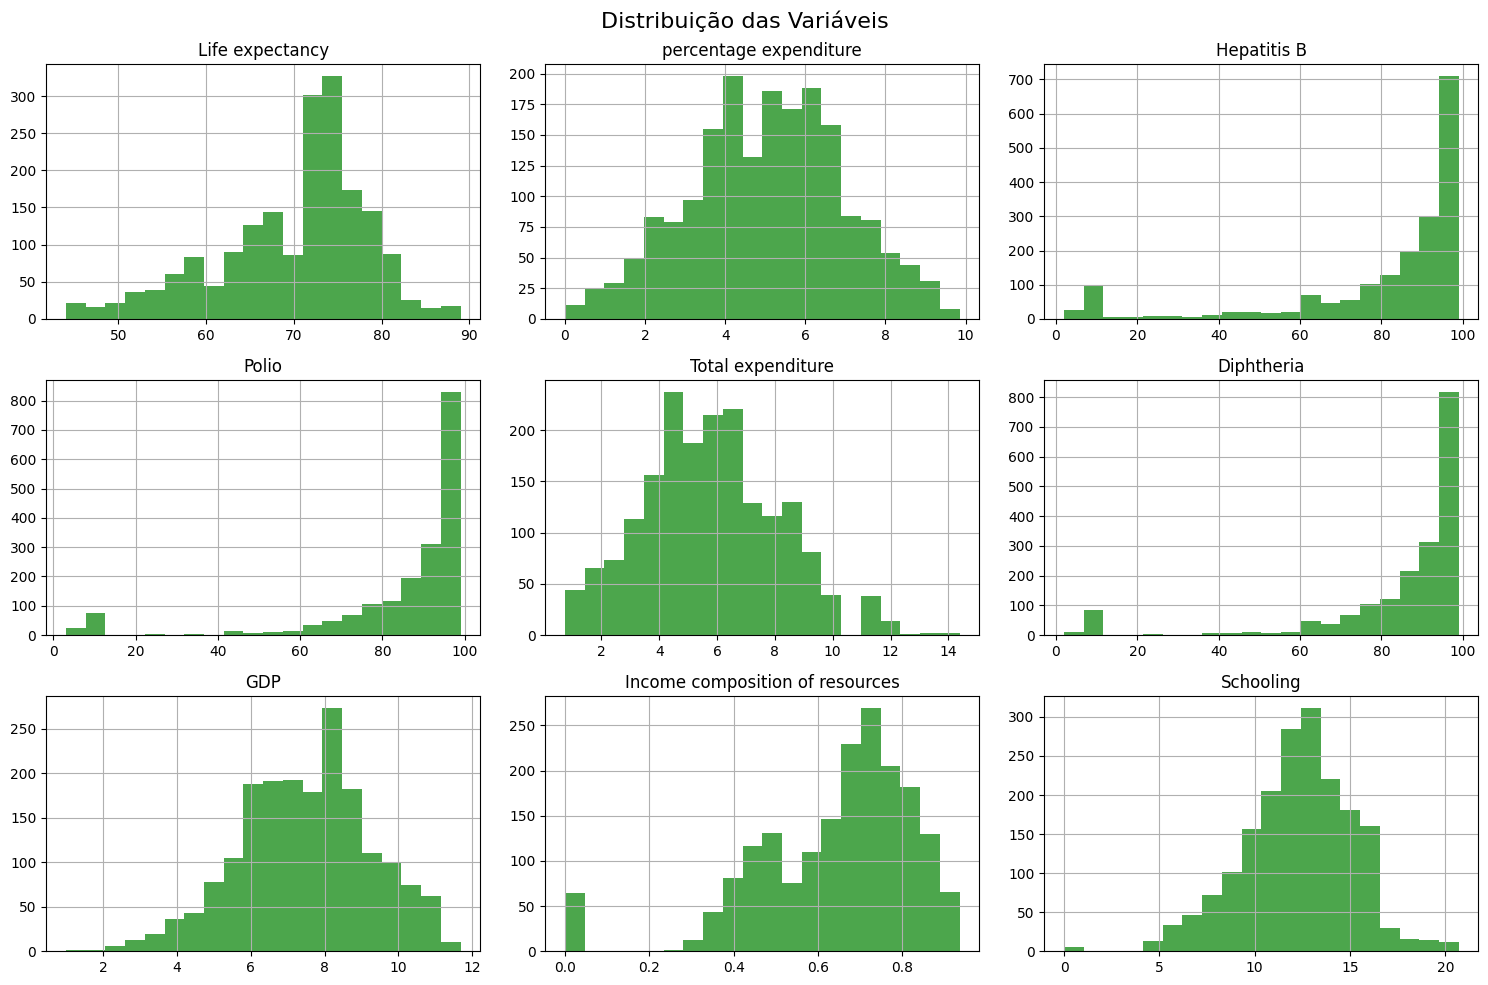

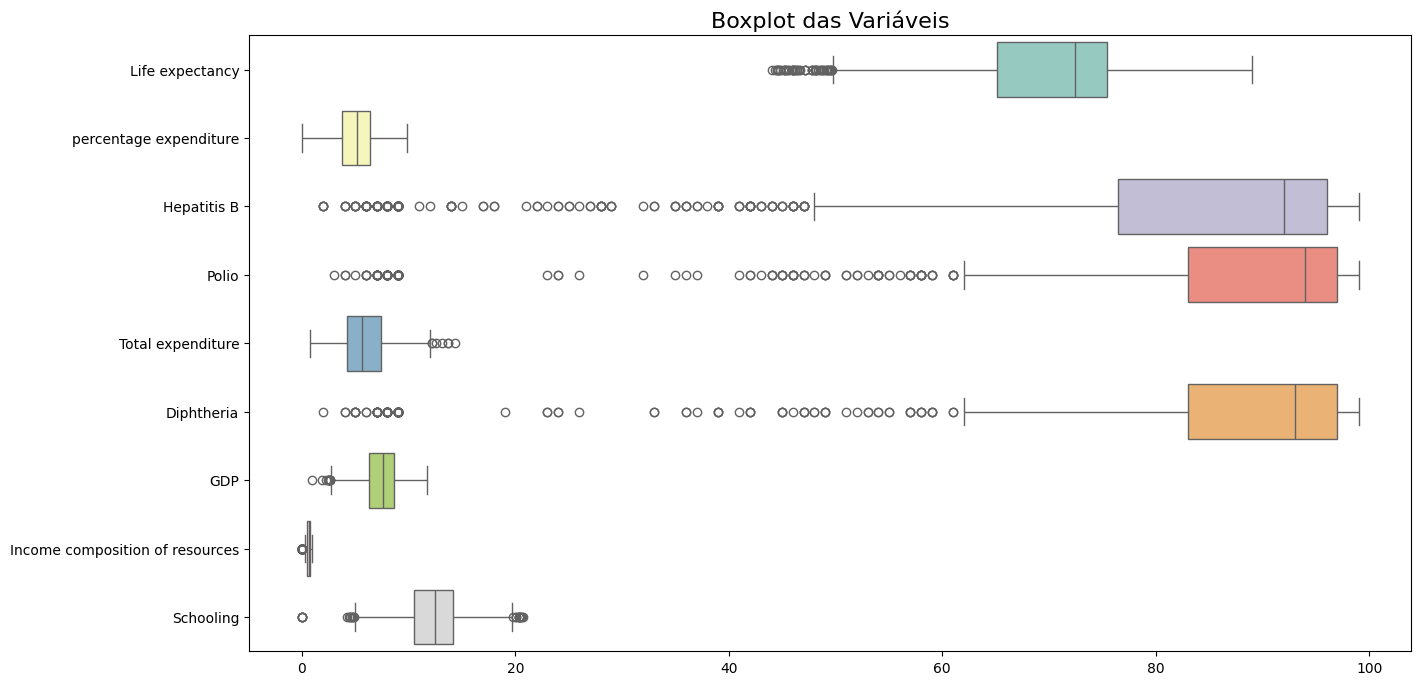

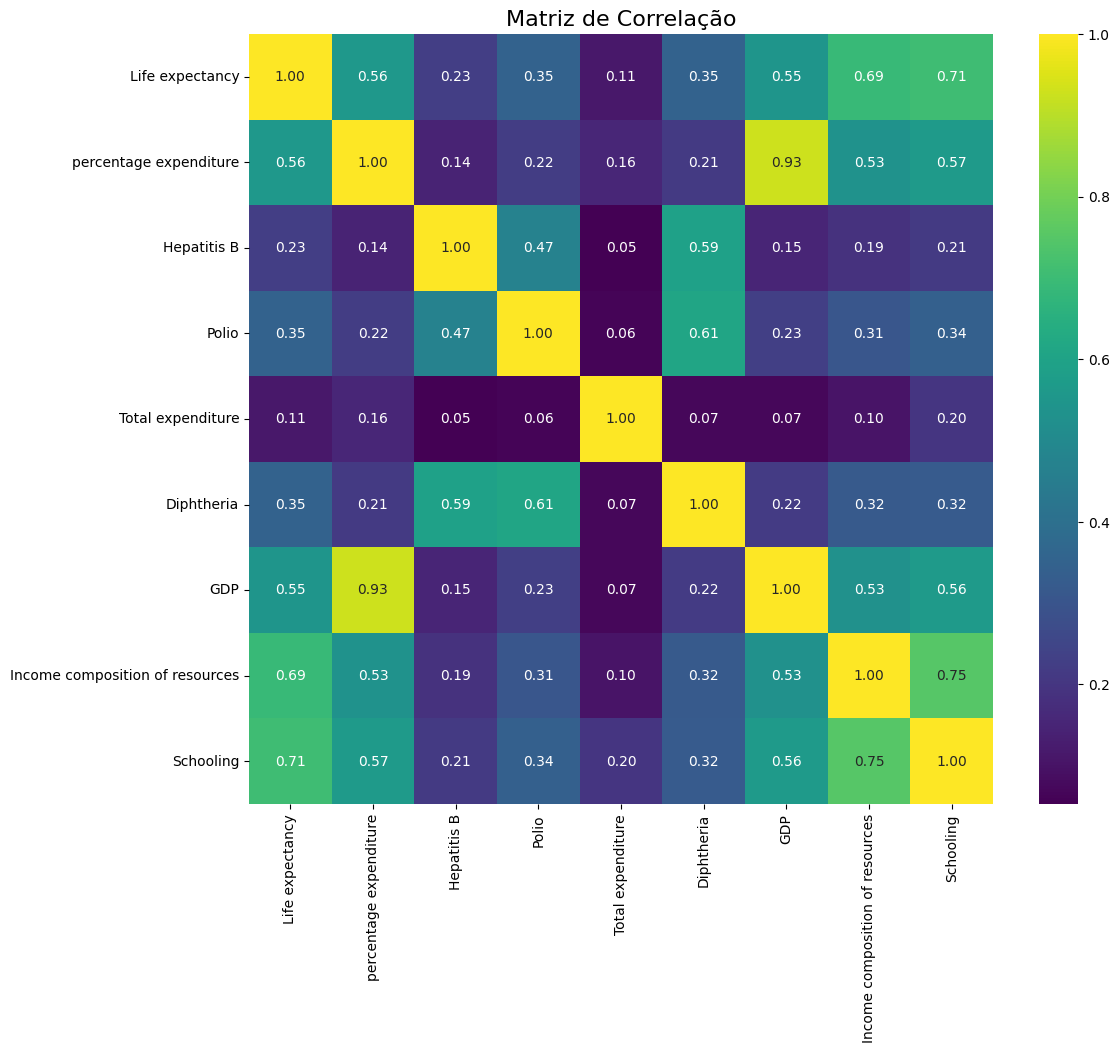

In [110]:
# Distribuição dos dados: Apos a transformação logarítmica

df_cleaned.hist(bins=20, figsize=(15, 10), color='green', alpha=0.7)
plt.suptitle("Distribuição das Variáveis", fontsize=16)
plt.tight_layout()
plt.show()

# Distribuição dos dados: Boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_cleaned, orient='h', palette="Set3")
plt.title("Boxplot das Variáveis", fontsize=16)
plt.show()

# Analisar correlações: Matriz de correlação com heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df_cleaned.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Matriz de Correlação", fontsize=16)
plt.show()




## 2.6 - Exportaçao dos dados para Modelação


In [97]:
# Exportar o dataset limpo para um ficheiro CSV
cleaned_data_path = './data/Life_Expectancy_Clean.csv'
df_cleaned.to_csv(cleaned_data_path, index=False)

# Confirmar a exportação
cleaned_data_path

print("Data_Clean exportado com sucesso!")


Data_Clean exportado com sucesso!
